# Increased Confidence in Metabolite Identity from CE-MS through Migration Time Prediction by Machine Learning with Scikit-Learn
---

> 20-December-2018


> Michael Loewen & Bill Zizek


> SCS 3253
--- 
## Introduction
**Capillary Electrophoresis (CE) - Mass Spectrometry (MS)** is a multi-dimensional analytical separation instrument used for analysis of biological samples among others. Upon injection, a current is applied and compounds within samples are separated as they migrate through the capillary by their respective electrophoretic mobility differences before reaching a time-of-flight (TOF) mass detector. In spite of CE-MS being a highly accurate and robust detection method, ambient and human variables can cause the same compound to migrate at different times despite otherwise identical conditions. This variability has no impact on the detection and quantification of compounds. However, dependable known migration times through a predictive model empowers replacement of expensive chemical standards through higher confidence of compound identification by additional evidence to accurate mass and isotopic pattern information and thus increases the value of datasets containing unknowns. With multiple experimental runs, there may be multiple instances of a compound and recorded migration times. This dynamic experimental data is annotated with relevant physicochemical properties and miscellaneous metadata to provide context to produced machine learning results. For respective compounds, chemical databases can be used to extract properties to perform calculations for relevant features such as effective mobility, molecular volume, and absolute compound mobility. Following training and profiling of model performance, further annotation to chemical compound classes can give context to results stemming from the model.

## Goal

This experiment aims to explore:

1. Using four independent variables (1. m/z, 2. pKa, 3. logP, and 4. Van der Waals molecular volume) can we predict a drug's relative migration time (FPhe_RMT)?
2. Can a machine learning algorithm improve accuracy in predicting FPhe_RMT over a standard linear regression approach?
3. Can we use machine learning to classify general drug classes using the aforementioned independent variables in question #1?

## Variables

`Experiment #` is a unique identifier corresponding to instrumental data acquisition. Each "experiment" takes 30-45 minutes and contains data for many different compounds. The experimental data captured per `Experiment #` is a measurd `m/z` value, `MT_sec`, and many other data points not relevant to the scope of this study.

`m/z` is a compound's mass-to-charge ratio (observed mass divided by charge number). In this study, each `Compound` has it's own respective `m/z` value but in practice many compounds can have the same `m/z` value.

`Compound` is a name identifier for drug compounds in this study. Compound identity has been confirmed already by `m/z`, relative migration time, and comigrating internal standards for unambiguous ID.

`MT_sec` is the migration time of a compound's peaks measured in seconds.

`FPhe_RMT` is a ratiometric calculation per `Experiment #`. A respective compounds `MT_sec` is divided by the `MT_sec` of F-Phe within the corresponding `Experiment #`.

`Drug Class` is a family classification that relates to the respective `Compound`.

`Monoisotopic Mass` is the sum of the masses of the atoms in a molecule using the unbound, ground-state, rest mass of the principal (most abundant) isotope.

`pKa`, `logP`, and `Van der Waals volume` are physicochemical properties pertinent to the theory of Capillary Electrophoresis that contribute to differences in compound migration time.

---

## Data Import and Exploratory Inspection

In [1]:
import pandas as pd
data = pd.read_csv("./data/MT_data.csv")
data.head()

,Experiment #,m/z,Compound,MT_sec,FPhe_RMT,Drug Class,pKa,logP,Van der Waals volume
0,1,141.1435,Amphetamine-d5,944.70,0.796207,Internal Standard,10.01,1.80,144.86
1,1,172.1332,Gabapentin,1018.32,0.858255,Other,9.91,-1.27,176.16
2,1,177.1022,Cotinine,967.56,0.815474,Other,4.79,0.21,165.31
3,1,178.1226,Mephedrone,1000.38,0.843135,Amphetamine,8.05,2.12,181.62
4,1,184.0768,F-Phe,1186.50,1.000000,Internal Standard,9.45,-1.04,160.46


![CompoundRMT Boxplot](./figures/compoundRMT_boxplot_clean.png)

In [2]:
data['Compound'].value_counts().head(10)

6-acetylmorphine    27
Venlafaxine         27
Flurazepam          27
F-Phe               27
Mephedrone          27
Propoxyphene        27
Methylone           27
Naloxone            27
Trazadone           27
Imipramine          27
Name: Compound, dtype: int64

In [3]:
data['Compound'].nunique()

57

In [4]:
data['Drug Class'].value_counts()

Opioid               512
Antidepressants      281
Sedative             189
Anesthetic           148
Other                122
Amphetamine          108
Stimulant             81
Internal Standard     54
Name: Drug Class, dtype: int64

![drugClassRMT Boxplot](./figures/drugClassRMT_box.png)

In [5]:
X = data[['m/z', 'pKa','logP', 'Van der Waals volume']] 
X.describe()

,m/z,pKa,logP,Van der Waals volume
count,1495.000000,1495.000000,1495.000000,1495.000000
mean,275.311918,8.425967,2.477358,258.485766
std,54.764365,2.254504,1.538750,48.712283
min,141.143500,2.650000,-1.350000,144.860000
25%,238.099300,8.050000,1.470000,233.740000
50%,282.087300,9.120000,2.530000,265.010000
75%,308.175700,9.760000,3.820000,285.750000
max,399.227800,13.780000,5.010000,376.570000


In [6]:
y = pd.DataFrame(data['FPhe_RMT'])
y.describe()

,FPhe_RMT
count,1495.000000
mean,0.914075
std,0.049119
min,0.772852
25%,0.888206
50%,0.916842
75%,0.938889
max,1.050100


### Split Data into Training and Test Sets

In [7]:
from sklearn.model_selection import train_test_split

random_seed = 42 # consistent integer to set random_state

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1046, 4) (449, 4) (1046, 1) (449, 1)


### Preprocess the data for analysis

In [8]:
from sklearn.preprocessing import StandardScaler

# remove the mean and scale to unit variance
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

pd.DataFrame(data = X_train_standardized, columns = X_train.columns).describe()

,m/z,pKa,logP,Van der Waals volume
count,1.046000e+03,1.046000e+03,1.046000e+03,1.046000e+03
mean,-1.062248e-15,7.217511e-18,4.755066e-17,-1.077804e-15
std,1.000478e+00,1.000478e+00,1.000478e+00,1.000478e+00
min,-2.448824e+00,-2.465132e+00,-2.483220e+00,-2.332043e+00
25%,-6.708792e-01,-1.798782e-01,-6.516023e-01,-5.013126e-01
50%,1.357590e-01,3.193487e-01,3.687799e-02,1.427800e-01
75%,6.141599e-01,5.883287e-01,8.650029e-01,5.699780e-01
max,2.283845e+00,2.324863e+00,1.647662e+00,2.440668e+00


## Evaluate Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_standardized, y_train)
print(reg.coef_, reg.intercept_)

[[ 0.01396473 -0.00749949 -0.01360099  0.02622007]] [0.91455164]


In [10]:
reg.score(X_train_standardized, y_train) #R^2 value

0.5279496969092903

Simple multi-variate linear regression provided a 52.8% accuracy on training set.

In [11]:
reg.score(X_test_standardized, y_test)

0.6134844763152294

Simple multi-variate linear regression provided a 61.3% accuracy on test set.

## Proposed Machine Learning Models

### Regression to forecast `FPhe_RMT`
* SGDRegressor
* RandomForestRegressor
* KNeighborsRegressor

### Testing SGDRegressor

In [12]:
import numpy as np
from sklearn import linear_model

sgdreg = linear_model.SGDRegressor(max_iter=1000, random_state=random_seed)
sgdreg.fit(X_train_standardized, y_train.values.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [13]:
sgdreg.score(X_train_standardized, y_train)

0.5279487126828264

SGDRegressor provided 52.8% accuracy on the training set which is in line with linear regression.

In [14]:
sgdreg.score(X_test_standardized, y_test)

0.6135730105490877

SGDRegressor provided 61.4% accuracy on the test set which is directly in line with linear regression.

### Testing RandomForestRegressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(random_state=random_seed, max_depth=8, n_estimators=10)
rfreg.fit(X_train_standardized, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [16]:
rfreg.score(X_train_standardized, y_train)

0.9852760911092715

RandomForestRegressor provided a 98.5% accuracy on training set, which is a substantial improvement compared to linear regression.

In [17]:
rfreg.score(X_test_standardized, y_test)

0.9844657866738478

RandomForestRegressor provided a 98.4% accuracy on test set, which is a substantial improvement compared to linear regression.

Let's try to do some hyperparameter tuning...

In [18]:
param_grid = { 
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['mse', 'mae']
}

In [19]:
from sklearn.model_selection import RandomizedSearchCV
import time

start = time.time()
n_iter_search = 40

CV_rfc = RandomizedSearchCV(rfreg, param_grid, n_iter=n_iter_search, cv=5)
CV_rfc.fit(X_train_standardized, y_train.values.ravel())

print("[INFO] randomized search took {:.2f} seconds".format(time.time() - start))

[INFO] randomized search took 535.28 seconds


In [20]:
# CV_rfc.best_params_
acc = CV_rfc.score(X_test_standardized, y_test)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(CV_rfc.best_params_))

[INFO] grid search accuracy: 98.47%
[INFO] grid search best parameters: {'n_estimators': 2000, 'max_features': 'auto', 'criterion': 'mse', 'max_depth': 8}


In [21]:
rfc_best = RandomForestRegressor(random_state=random_seed, 
                                 n_estimators= 1050, 
                                 max_features='sqrt',
                                 max_depth=8, 
                                 criterion='mse')

In [22]:
rfc_best.fit(X_train_standardized, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1050, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
rfc_best.score(X_test_standardized, y_test)

0.9860813897621115

With some hyperparameter tuning from a RandomizedSearch, accuracy was improved slightly to 98.6% on the test set.

Let's investigate what features are the most important to the accuracy of this model.

In [24]:
feature_imp = pd.Series(rfc_best.feature_importances_,index=list(X.columns.values)).sort_values(ascending=False)
feature_imp

m/z                     0.401511
Van der Waals volume    0.303002
logP                    0.187124
pKa                     0.108363
dtype: float64

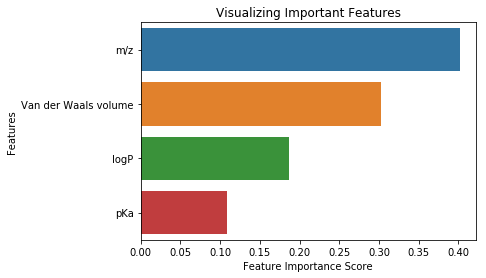

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In normal situations, it might be worth removing `pKa` as a feature as a means to improve the accuracy score of the model. However, we will leave this as a future consideration since the current accuracy score is nearing 100% and there is an underlying theoretical importance to the impact of the feature on the data.

#### Visualizing a Single Decision Tree

In [26]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Seroclinix/Downloads/graphviz-2.38/release/bin'

In [27]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rfc_best.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = list(X.columns.values), rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

![tree](./figures/tree.png)

Looks good! This is an intuitive look under the hood of one of the trees in the forest. We can see the variable and value to split the Node on with the mean squared error of the Node. Further, we also can see how many data points are in the Node and the prediction for all data points in the Node. Then we have our Leaf Nodes at the bottom.

Random Forests appears to be a highly accurate model in predicting migration time.

### Testing KNN

In [28]:
#Testing KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

KNreg = KNeighborsRegressor(n_neighbors=23)
KNreg.fit(X_train_standardized, y_train.values.ravel())

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=23, p=2,
          weights='uniform')

In [29]:
KNreg.score(X_train_standardized, y_train)

0.9695800010246135

KNeighborsRegressor provided a 96.95% accuracy on training set, which is drastically improved from 60-70% observed in linear methods.

In [30]:
KNreg.score(X_test_standardized, y_test)

0.9665064889496633

KNeighborsRegressor provided a 96.65% accuracy on training set, which is drastically improved from 60-70% observed in linear methods.

Let's make sure we're not overfitting.

In [31]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Using CV to test bias vs variance trade-off

In [32]:
# rmse_val = [] #to store rmse values for different k
variance_val = []
bias_val = []
k_val = []
train_scores = []
test_scores = []

from sklearn.model_selection import cross_val_score

for K in range(0,50):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    k_val.append(K)
    
    model.fit(X_train_standardized, y_train)  #fit the model
    pred=model.predict(X_test_standardized) #make prediction on test set
    error = sqrt(mean_squared_error(y_test, pred)) #calculate rmse

#     rmse_val.append(error) #store rmse values
    variance_val.append(error**2)
    
    bias = np.sum(np.subtract(y_test, pred))
    bias_val.append(bias**2)
    
    train_score = cross_val_score(model, X_train_standardized, y_train, cv=3)
    train_scores.append(train_score.mean())

    test_score = model.score(X_test_standardized, y_test)
    test_scores.append(test_score.mean())

    
#     print('For k =', K , ' Variance:', error**2, ' Bias:', bias)

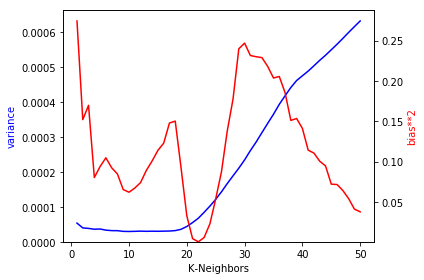

In [33]:
#plotting the rmse values against k values

fig, ax1 = plt.subplots()

ax1.plot(k_val, variance_val, 'b-')
ax1.set_ylim([0.000,np.max(variance_val)*1.05])
ax1.set_ylabel('variance', color='b')
ax1.set_xlabel('K-Neighbors')

ax2 = ax1.twinx()
ax2.plot(k_val, bias_val, 'r-')
ax2.set_ylim([np.min(bias_val), np.max(bias_val)*1.05])
ax2.set_ylabel('bias**2', color='r')

fig.tight_layout()
plt.show()

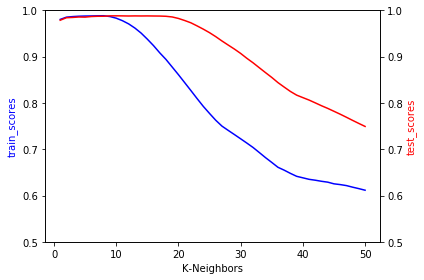

In [34]:
#plotting the train and test scores versus k values

fig, ax1 = plt.subplots()

ax1.plot(k_val, train_scores, 'b-')
ax1.set_ylim([0.5,1.0])
ax1.set_ylabel('train_scores', color='b')
ax1.set_xlabel('K-Neighbors')

ax2 = ax1.twinx()
ax2.plot(k_val, test_scores, 'r-')
ax2.set_ylim(0.5, 1.0)
ax2.set_ylabel('test_scores', color='r')

fig.tight_layout()
plt.show()

In [35]:
from sklearn.model_selection import cross_val_score

KNreg = KNeighborsRegressor(n_neighbors=20)
KNreg.fit(X_train_standardized, y_train.values.ravel())

scores = cross_val_score(KNreg, X_train_standardized, y_train, cv=3)
scores 

array([0.90899637, 0.78855098, 0.88584238])

In [36]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.861 (+/- 0.104)


In [37]:
testscores = KNreg.score(X_test_standardized, y_test)
testscores 

0.9826210907713899

Due to the relatively small size of the data, extensive cross-validation cannot be completed. However, a 3-fold cross validation yielded 86% accuracy with the test set performing at 98.2% accuracy. These scores also factor in that bias and variance is minimized in the model's predictions.

## Classification of Drug Class

* K-Neast Neighbors
* Random Forest

### Preparing the Data

In [39]:
X = data[['m/z', 'pKa','logP', 'Van der Waals volume']] 
y_class = pd.DataFrame(data['Drug Class'])
y_class.head()

,Drug Class
0,Internal Standard
1,Other
2,Other
3,Amphetamine
4,Internal Standard


In [40]:
# Create categories for y variable

from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
y_lb = lb.fit_transform(y_class)
lb.classes_

array(['Amphetamine', 'Anesthetic', 'Antidepressants',
       'Internal Standard', 'Opioid', 'Other', 'Sedative', 'Stimulant'],
      dtype='<U17')

In [41]:
y_class_lb = pd.DataFrame(data = y_lb, columns=lb.classes_)
y_class_lb.head()

,Amphetamine,Anesthetic,Antidepressants,Internal Standard,Opioid,Other,Sedative,Stimulant
0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class_lb, test_size=0.3, random_state=random_seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1046, 4) (449, 4) (1046, 8) (449, 8)


In [43]:
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

### KNeighborsClassifier

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_standardized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=24, p=2,
           weights='uniform')

In [45]:
cross_val_score(knn, X_train_standardized, y_train, cv=3)

1.0

In [46]:
knn.score(X_test_standardized, y_test)

1.0

### RandomForestClassifier

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=random_seed)
rf.fit(X_train_standardized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [66]:
rfCV = cross_val_score(rf, X_train_standardized, y_train, cv=3)
rfCV.mean()

1.0

In [67]:
rf.score(X_test_standardized, y_test)

1.0

## Conclusion

In conclusion, as a proof of concept we show promising results towards all of our goals at the outset of the project. Both `KNeighborsClassifier` and `RandomForestRegressor` yielded promising accuracy in predicting different drug's relative migration time while minimizing overfitting. Linear methods demonstrated accuracy around 60-70% whereas the aforementioned methods achieved accuracy scores on the test sets >95%. Finally, we also are able to classify drug class with these same methods to a high degree of accuracy.